# Sampling on binarized MNIST

**Note:**

sklearn == 0.21.3 required for imblearn 0.5.0 to work. It's easiest to create a new conda env from scratch with sklearn and imblearn.

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from sklearn import ensemble, metrics, base, linear_model
import pandas as pd
import seaborn as sns
import tqdm
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [2]:
plt.style.use('bmh')

In [3]:
%%time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

CPU times: user 12 s, sys: 953 ms, total: 12.9 s
Wall time: 13 s


In [4]:
X.shape, X[:5,:5], y[:5]

((70000, 784),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array(['5', '0', '4', '1', '9'], dtype=object))

In [5]:
X = pd.DataFrame(X).add_prefix('pixel')
y = pd.DataFrame({'class':y})
y = y['class'].astype('category')

In [6]:
display(X.head(), y.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [7]:
df = X.join(y)
len(df), display(df.head())

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


(70000, None)

## Pre-processing

### Binarizing

Reducing to 0 and 1

In [12]:
def get_share_and_count(df:pd.DataFrame, col:str='class'):
    share = df[col].value_counts(normalize=True).rename('share')
    count = df[col].value_counts(normalize=False).rename('count')
    return share.to_frame().join(count)

def make_binary(df:pd.DataFrame, set0:set, set1:set):
    'Binarize any two sets of classes and return a DataFrame for only those classes labeled as False or True'
    assert len(set0) > 0 and len(set1) > 0
    assert set0 != set1
    
    df_b0 = df.loc[df['class'].isin(set0)].copy()
    df_b1 = df.loc[df['class'].isin(set1)].copy()
    df_b0['class'] = False
    df_b1['class'] = True
    
    df_b = pd.concat((df_b0, df_b1))
    df_b['class'] = df_b['class'].astype('category')
    return df_b

In [13]:
%%time
df_b = make_binary(df, {'0', '1'}, {'4'})
print(f'df: {len(df)}, df_b: {len(df_b)}')
display(get_share_and_count(df_b))

df: 70000, df_b: 21604


,share,count
False,0.684133,14780
True,0.315867,6824


CPU times: user 93.8 ms, sys: 281 ms, total: 375 ms
Wall time: 374 ms


In [14]:
%%time
df_b = make_binary(df, {'0'}, {'8'})
print(f'df: {len(df)}, df_b: {len(df_b)}')

df: 70000, df_b: 13728
CPU times: user 46.9 ms, sys: 234 ms, total: 281 ms
Wall time: 272 ms


### Get skewed training set & balanced test set

In [15]:
def get_skewed_train_and_balanced_test_set(df_b:pd.DataFrame, train_frac:float=.8, skew_frac:float=.02,
                                           class_to_skew:bool=True, verbose:bool=False):
    '''Generates a balanced test set and a skewed training set with `class_to_skew` 
    making up the fraction `skew_frac` of the total.
    
    Works with the `df_b` produced by `make_binary`.
    '''
    df_test = df_b.sample(frac=1-train_frac)
    df_train = df_b.loc[~df_b['class'].index.isin(df_test.index)]
    
    n = min(df_train['class'].value_counts().values)
    n_skew = int(n * skew_frac / (1 - skew_frac))
    
    df_train = pd.concat((
        df_train.loc[df_train['class']==class_to_skew].iloc[:n].sample(n=n_skew),
        df_train.loc[df_train['class']!=class_to_skew].iloc[:n]
    ))
    
    if verbose:
        print(f'train set: {len(df_train)}')
        display(get_share_and_count(df_train))
        print(f'test set: {len(df_test)}')
        display(get_share_and_count(df_test))
    return df_train, df_test

In [16]:
%%time
df_train, df_test = get_skewed_train_and_balanced_test_set(df_b, train_frac=.8, skew_frac=.02, class_to_skew=True,
                                                           verbose=True)

train set: 5574


,share,count
False,0.980086,5463
True,0.019914,111


test set: 2746


,share,count
False,0.524399,1440
True,0.475601,1306


CPU times: user 62.5 ms, sys: 93.8 ms, total: 156 ms
Wall time: 131 ms


In [17]:
def get_Xy(df:pd.DataFrame, x_col_pattern:str='pixel', y_col:str='class'):
    x_cols = [c for c in df.columns if c.startswith(x_col_pattern)]
    X = df.loc[:,].values.astype(float)
    y = df.loc[:, y_col].values.astype(int)
    return X, y

In [18]:
X_train, y_train = get_Xy(df_train)
X_train[:5,:5], y_train[:5], X_train.shape, y_train.shape

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([1, 1, 1, 1, 1]),
 (5574, 785),
 (5574,))

In [19]:
X_test, y_test = get_Xy(df_test)
X_test[:5,:5], y_test[:5], X_test.shape, y_test.shape

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([1, 1, 0, 1, 0]),
 (2746, 785),
 (2746,))

### Impact of sampler on the cardinality of `X`

In [20]:
def get_X_cardinality(X:np.ndarray):
    return len(set([tuple(x) for x in X]))

Unsampled

In [21]:
print(f'train - samples: {len(X_train)}, cardinality: {get_X_cardinality(X_train)}')

train - samples: 5574, cardinality: 5574


`RandomOverSampler`

In [22]:
_X, _y = RandomOverSampler().fit_resample(X_train, y_train)
print(f'train - samples: {len(_X)}, cardinality: {get_X_cardinality(_X)}')

train - samples: 10926, cardinality: 5574


`SMOTE`

In [23]:
_X, _y = SMOTE().fit_resample(X_train, y_train)
print(f'train - samples: {len(_X)}, cardinality: {get_X_cardinality(_X)}')

train - samples: 10926, cardinality: 10926


## Going nuts

In [24]:
def ELWMS(df:pd.DataFrame, set0:set={'0'}, set1:set={'1'}, n_rep:int=10, 
          train_frac:float=.8, skew_frac:float=.02, class_to_skew:bool=True,
          model_specs:dict=None, model_class:base.ClassifierMixin=linear_model.LogisticRegression,
          samplers:dict={'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}, verbose:bool=False):
    '''Eierlegendewollmilchsau (performs all the steps above repeatedly)
    
    set0: defines which MNIST classes are mapped to False/0
    set1: defines which MNIST classes are mapped to True/1
    train_frac: defines how large the training set is
    skew_frac: defines how large the class True in the training set is
    
    Tip: If you want a tiny training set which is heavily skewed towards the class False
    set `train_frac` = .1, `skew_frac` = .02 and `class_to_skew` = False. This yields
    a training set with 2% True, 98% False, based on 10% of the complete data.
    '''
    
    results = []
    
    if model_specs is None:
        model_specs = dict()
    elif isinstance(model_class, ensemble.RandomForestClassifier) and model_specs is None:
        model_specs = dict(n_estimators=100, max_features='sqrt')
    
    
    for rep in range(n_rep):
        
        # binarizing sets of MNIST classes
        df_b = make_binary(df, set0, set1)
        
        # splitting and skewing
        df_train, df_test = get_skewed_train_and_balanced_test_set(df_b, train_frac=train_frac, 
                                                                   skew_frac=skew_frac, 
                                                                   class_to_skew=class_to_skew)
        if verbose:
            print(f'\nrep {rep+1}/{n_rep}\n\ttraining set: {len(df_train)}, test set: {len(df_test)}')
            print('class share in training set')
            display(get_share_and_count(df_train))
            print('class share in test set')
            display(get_share_and_count(df_test))
        
        # collecting X and y
        X_train, y_train = get_Xy(df_train)
        X_test, y_test = get_Xy(df_test)
        
        # going through the different samplers
        for name, sampler in samplers.items():
            if sampler is None:
                _X_train, _y_train = X_train.copy(), y_train.copy()
            else:
                sam = sampler()
                _X_train, _y_train = sam.fit_resample(X_train, y_train)

            model = model_class(**model_specs)
            model.fit(_X_train, _y_train)

            y_pred = model.predict(X_test)
            y_score = model.predict_proba(X_test)
            roc_auc_True = metrics.roc_auc_score(y_test == True, y_score[:,1])
            roc_auc_False = metrics.roc_auc_score(y_test == False, y_score[:,0])
            
            res = metrics.classification_report(y_test, y_pred, output_dict=True)
            d = {k:v for k,v in res.items() if not isinstance(v,dict)}
            d['sampler'] = name
            d['1->roc auc'] = roc_auc_True
            d['0->roc auc'] = roc_auc_False
            for k,v in res.items():
                if isinstance(v,dict):
                    d.update({f'{k}->{_k}': _v for _k,_v in v.items()})
            results.append(d)
            
    results = pd.DataFrame(results)
    results['train_frac'] = train_frac
    return results

### Testing a single parameter combination

In [ ]:
samplers = {'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}
model_class = linear_model.LogisticRegression
model_specs = {'solver':'lbfgs'}

# assigning classes into groups for binarization (can use multiple classes per group)
set0 = {'0'}  # all 0s belong to set 0
set1 = {'8'}  # all 8s belong to set 8

results = ELWMS(df, 
                set0=set0, set1=set1, 
                n_rep=10, 
                train_frac=.8, skew_frac=.02, class_to_skew=True,
                model_class=model_class, model_specs=model_specs, samplers=samplers,
                verbose=True)

In [33]:
results.head()

,accuracy,sampler,1->roc auc,0->roc auc,0->precision,0->recall,0->f1-score,0->support,1->precision,1->recall,...,1->support,macro avg->precision,macro avg->recall,macro avg->f1-score,macro avg->support,weighted avg->precision,weighted avg->recall,weighted avg->f1-score,weighted avg->support,train_frac
0,0.961763,ROS,0.997056,0.996041,0.931607,0.998577,0.963930,1405,0.998387,0.923192,...,1341,0.964997,0.960884,0.961624,2746,0.964219,0.961763,0.961678,2746,0.8
1,0.959942,SMOTE,0.997016,0.996024,0.928524,0.998577,0.962277,1405,0.998381,0.919463,...,1341,0.963452,0.959020,0.959788,2746,0.962638,0.959942,0.959846,2746,0.8
2,0.953751,nothing,0.996992,0.996210,0.918194,0.998577,0.956700,1405,0.998358,0.906786,...,1341,0.958276,0.952681,0.953535,2746,0.957342,0.953751,0.953609,2746,0.8
3,0.967225,ROS,0.997044,0.996764,0.939142,0.998529,0.967926,1360,0.998462,0.936508,...,1386,0.968802,0.967519,0.967209,2746,0.969083,0.967225,0.967203,2746,0.8
4,0.966133,SMOTE,0.997057,0.996772,0.937198,0.998529,0.966892,1360,0.998458,0.934343,...,1386,0.967828,0.966436,0.966115,2746,0.968118,0.966133,0.966107,2746,0.8


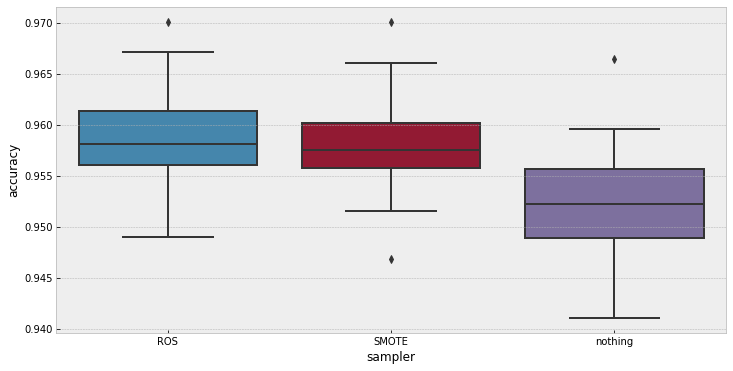

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=results, x='sampler', y='accuracy', ax=ax)
plt.show()

To more clearly see the difference of using samplers, the scores are subtracted by the median of the values obtained for the case without a sampler, labelled 'nothing'.

In [35]:
def get_score_difference_to_reference_sampler(df:pd.DataFrame, agg_func_for_reference:Callable=np.median,
                                      reference_sampler:str='nothing'):
    'Expects the output of `ELWMS` as input'
    delta = df.copy()
    cols = [c for c in delta.columns if c != 'sampler' and c!= 'train_frac']
    ref = delta.loc[delta['sampler']=='nothing', cols].agg(agg_func_for_reference, axis=0)
    delta.loc[:, cols] = delta.loc[:, cols] - ref
    return delta

In [36]:
results_delta = get_score_difference_to_reference_sampler(results,
                                                          agg_func_for_reference=np.median)
results_delta.head()

,accuracy,sampler,1->roc auc,0->roc auc,0->precision,0->recall,0->f1-score,0->support,1->precision,1->recall,...,1->support,macro avg->precision,macro avg->recall,macro avg->f1-score,macro avg->support,weighted avg->precision,weighted avg->recall,weighted avg->f1-score,weighted avg->support,train_frac
0,0.009468,ROS,-0.000159,-0.000958,0.015908,-0.000347,0.008605,24.0,-0.000433,0.019395,...,-24.0,0.007947,0.009341,0.009520,0.0,0.007946,0.009468,0.009525,0.0,0.8
1,0.007647,SMOTE,-0.000200,-0.000975,0.012826,-0.000347,0.006952,24.0,-0.000439,0.015666,...,-24.0,0.006403,0.007477,0.007684,0.0,0.006365,0.007647,0.007692,0.0,0.8
2,0.001457,nothing,-0.000223,-0.000788,0.002495,-0.000347,0.001375,24.0,-0.000462,0.002989,...,-24.0,0.001226,0.001139,0.001432,0.0,0.001069,0.001457,0.001456,0.0,0.8
3,0.014931,ROS,-0.000171,-0.000235,0.023444,-0.000394,0.012601,-21.0,-0.000358,0.032711,...,21.0,0.011752,0.015976,0.015106,0.0,0.012810,0.014931,0.015049,0.0,0.8
4,0.013838,SMOTE,-0.000158,-0.000227,0.021499,-0.000394,0.011567,-21.0,-0.000362,0.030546,...,21.0,0.010778,0.014894,0.014011,0.0,0.011845,0.013838,0.013954,0.0,0.8


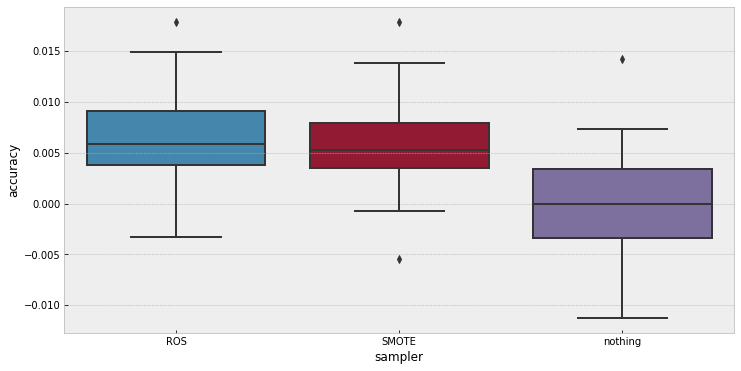

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=results_delta, x='sampler', y='accuracy', ax=ax)
plt.show()

### Scanning a range of `train_frac` values

In [73]:
samplers = {'ROS':RandomOverSampler, 'SMOTE': SMOTE, 'nothing': None}
model_class = linear_model.LogisticRegression
model_specs = {'solver':'lbfgs'}

set0 = {'0','8'}
set1 = {'1','2'}

n_rep = 20

# The value True will make up about 2% of the training set
skew_frac = .02
class_to_skew = True

settings = dict(samplers=samplers, model_class=model_class, model_specs=model_specs, set0=set0, set1=set1,
                n_rep=n_rep, skew_frac=skew_frac, class_to_skew=class_to_skew)

train_frac_range = [.8, .6, .4, .2, .1]

In [ ]:
%%time
scan_results = []
scan_results_delta = []

for train_frac in tqdm.tqdm(train_frac_range, total=len(train_frac_range)):
    _results = ELWMS(df, train_frac=train_frac,
                     **settings)
    scan_results.append(_results)
    
    # for clearer visualisation of the effect of samplers vs no sampling
    _results_delta = get_score_difference_to_reference_sampler(_results,
                                                               agg_func_for_reference=np.median)
    
    scan_results_delta.append(_results_delta)
        
scan_results = pd.concat(scan_results, ignore_index=True)
scan_results_delta = pd.concat(scan_results_delta, ignore_index=True)

#### Plotting score vs sampler and training / test set size

Grouping by sampler

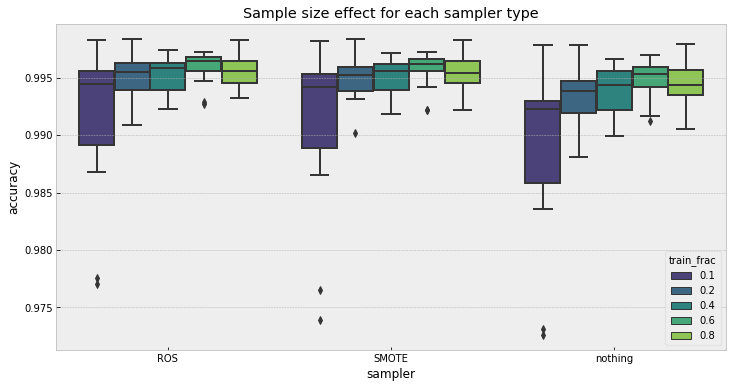

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='accuracy', hue='train_frac', data=scan_results,
                 ax=ax, palette='viridis')
ax.set(title='Sample size effect for each sampler type')
plt.show()

Grouping by `train_frac`

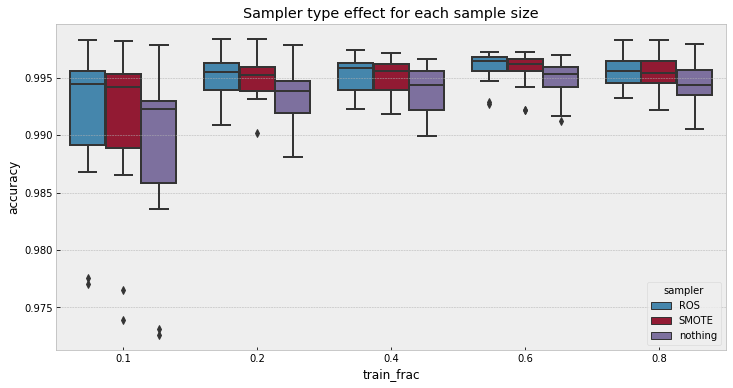

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='accuracy', hue='sampler', data=scan_results,
                 ax=ax)
ax.set(title='Sampler type effect for each sample size')
plt.show()

#### Plotting score DIFFERENCE vs sampler and training / test set size

To more clearly see the difference of using samplers, the scores are subtracted by the median of the values obtained for the case without a sampler, labelled 'nothing'.

In [52]:
plot_mask = scan_results_delta['sampler']!='nothing'

**Accuracy** - Grouping by sampler

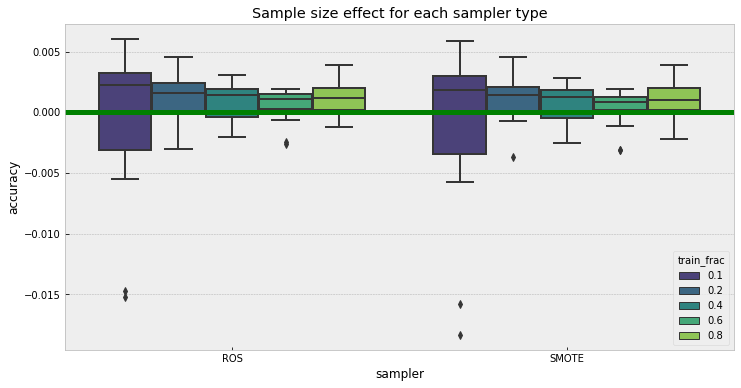

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='accuracy', hue='train_frac', 
                 data=scan_results_delta.loc[plot_mask,:],
                 ax=ax, palette='viridis')
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '-g', lw=5)
ax.set(title='Sample size effect for each sampler type', xlim=xlim)
plt.show()

**Accuracy** - Grouping by `train_frac`

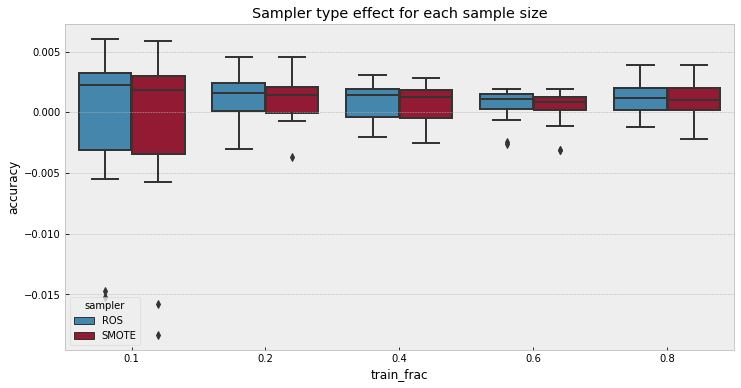

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='accuracy', hue='sampler', 
                 data=scan_results_delta.loc[plot_mask,:],
                 ax=ax)
ax.set(title='Sampler type effect for each sample size')
plt.show()

**F1-score (for 1)** Grouping by sampler

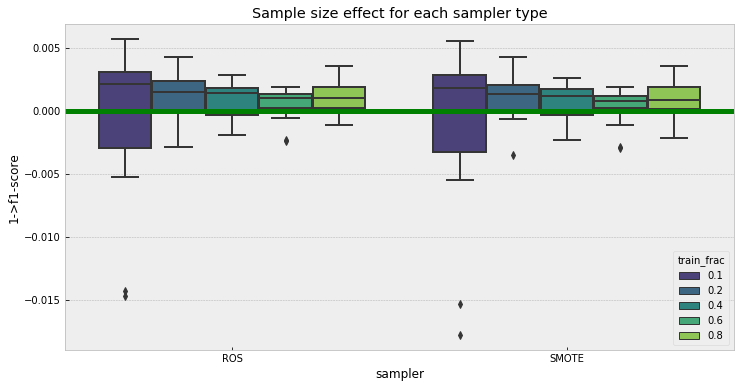

In [71]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='sampler', y='1->f1-score', hue='train_frac', 
                 data=scan_results_delta.loc[plot_mask],
                 ax=ax, palette='viridis')
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '-g', lw=5)
ax.set(title='Sample size effect for each sampler type', xlim=xlim)
plt.show()

**F1-score (for 1)** Grouping by `train_frac`

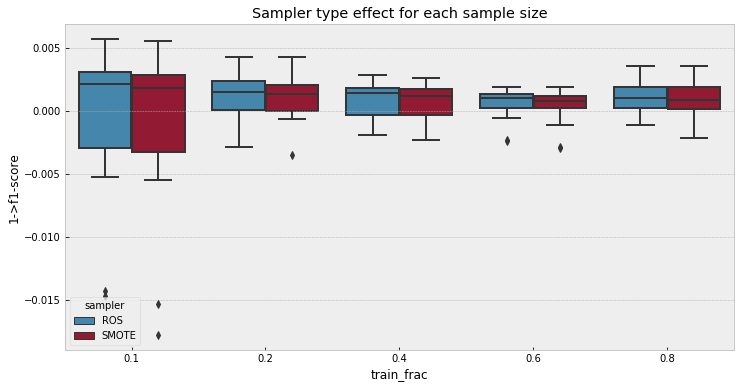

In [56]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x='train_frac', y='1->f1-score', hue='sampler', 
                 data=scan_results_delta.loc[plot_mask],
                 ax=ax)
ax.set(title='Sampler type effect for each sample size')
plt.show()

## Summary

It seems the samplers `RandomOverSampler` and `SMOTE` behave similar, using their default settings, in showing increasingly larger gains over no sampler ('nothing') the smaller the training data set is.